In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

In [ ]:
!pip install pytorch_lightning==1.9.4
!pip install pytorch_forecasting==0.10.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 14.9 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import sys
import os
import argparse
import shutil
import random
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics import QuantileLoss

from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.models import TemporalFusionTransformer

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


In [ ]:
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [ ]:
def seed_all(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
#경로만 자신의 환경에 맞게 잘 설정해주세요!
DATAROOT='/content/drive/MyDrive/Aimers3'
CKPTROOT = DATAROOT+"/ckpts" # directory for model checkpoints
CSVROOT = DATAROOT+"/csvs" # directory for prediction outputs
SUBFN = DATAROOT+"/sub.csv" # final submission file path
LOGDIR = DATAROOT+"/logs" # pytorch_forecasting requirs logger

In [ ]:
cnt = pd.read_csv('/content/drive/MyDrive/Aimers3/brand_keyword_cnt.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/Aimers3/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Aimers3/train.csv')
sales = pd.read_csv('/content/drive/MyDrive/Aimers3/sales.csv')
info = pd.read_csv('/content/drive/MyDrive/Aimers3/product_info.csv')

In [ ]:
date_columns = train.columns[6:]
train = train.melt(id_vars=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'],
                             value_vars=date_columns,
                             var_name='날짜',
                             value_name='값')
train['날짜'] = pd.to_datetime(train['날짜'])
train

,ID,제품,대분류,중분류,소분류,브랜드,날짜,값
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,2022-01-01,0
...,...,...,...,...,...,...,...,...
7293505,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,2023-04-04,0
7293506,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,2023-04-04,3
7293507,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,2023-04-04,0
7293508,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,2023-04-04,2


In [ ]:
train = train.sort_values(['ID','날짜'])
train = train.reset_index(drop = True)
train.drop(['제품','대분류','중분류','소분류','브랜드'],axis=1,inplace=True)
train = train.fillna(0)
train

,ID,날짜,값
0,0,2022-01-01,0
1,0,2022-01-02,0
2,0,2022-01-03,0
3,0,2022-01-04,0
4,0,2022-01-05,0
...,...,...,...
7293505,15889,2023-03-31,0
7293506,15889,2023-04-01,0
7293507,15889,2023-04-02,0
7293508,15889,2023-04-03,0


In [ ]:
date_columns = submission_df.columns[1:]
submission_df = submission_df.melt(id_vars=['ID'],
                             value_vars=date_columns,
                             var_name='날짜',
                             value_name='값')
submission_df['날짜'] = pd.to_datetime(submission_df['날짜'])
submission_df

,ID,날짜,값
0,0,2023-04-05,0
1,1,2023-04-05,0
2,2,2023-04-05,0
3,3,2023-04-05,0
4,4,2023-04-05,0
...,...,...,...
333685,15885,2023-04-25,0
333686,15886,2023-04-25,0
333687,15887,2023-04-25,0
333688,15888,2023-04-25,0


In [ ]:
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df = submission_df.sort_values(['ID','날짜'])
submission_df = submission_df.reset_index(drop = True)
submission_df

,ID,날짜,값
0,0,2023-04-05,0
1,0,2023-04-06,0
2,0,2023-04-07,0
3,0,2023-04-08,0
4,0,2023-04-09,0
...,...,...,...
333685,15889,2023-04-21,0
333686,15889,2023-04-22,0
333687,15889,2023-04-23,0
333688,15889,2023-04-24,0


In [ ]:
# 누락된 값을 'Unknown'으로 대체
#train.fillna('Unknown', inplace=True)
#submission_df.fillna('Unknown', inplace=True)

# ID 열을 문자열로 변환
train['ID'] = train['ID'].astype(str)
submission_df['ID'] = submission_df['ID'].astype(str)

In [ ]:
__ix = train.columns.get_loc('날짜')
train['날짜'] = (train.loc[:, '날짜'] - train.iloc[0, __ix]).astype('timedelta64[D]').astype('int')
train

,ID,날짜,값
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
7293505,15889,454,0
7293506,15889,455,0
7293507,15889,456,0
7293508,15889,457,0


In [ ]:
train.rename(columns={
    '키워드_값' : 'key',
    '값' : 'target',
    '날짜' : 'time_idx'
}, inplace=True)
train

,ID,time_idx,target
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
7293505,15889,454,0
7293506,15889,455,0
7293507,15889,456,0
7293508,15889,457,0


In [ ]:
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)

In [ ]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 21

train['target'] = train['target'].astype(float)
train['ID'] = train['ID'].astype(str) # 문자열로 변환
context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="target",
    categorical_encoders={"ID": NaNLabelEncoder().fit(train.ID)},
    group_ids=["ID"],
    target_normalizer=GroupNormalizer(groups=['ID'], transformation="softplus"),
    # only unknown variable is "target" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["target"],
    #min_encoder_length=30,
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Training without validation
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    stack_types=['trend', 'seasonality'],
    num_blocks=[3, 3],
    num_block_layers=[3, 3],
    widths=[32, 512],
    dropout=0.1,
    #prediction_length=21,
    context_length=60,
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logg

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f'best_model_path={best_model_path}')
best_tft = NBeats.load_from_checkpoint(best_model_path)

best_model_path=/content/lightning_logs/version_1/checkpoints/epoch=2-step=450.ckpt


# 여기까지 그대로 실행하시고 위에 주소를 밑에 복사하면됩니다

In [ ]:
def forecast(ckpt, train_df,tr_ds):
    # 모델 로드
    best_tft = NBeats.load_from_checkpoint(ckpt)
    max_encoder_length = best_tft.dataset_parameters['max_encoder_length']
    print(max_encoder_length)
    max_prediction_length = 21

    # 마지막 5주 데이터 사용
    encoder_data = train_df[lambda x: x.time_idx > x.time_idx.max() - 60]
    encoder_data.to_csv('encoder.csv',index=False)
    # 마지막 행 추출
    last_data = train_df.iloc[[-1]]
    #encoder_data = encoder_data[encoder_data['ID'] == "224"]
    # 테스트 데이터 준비 (21일 예측)
    #decoder_data = train_df.iloc[[-1]].copy()
    #print(decoder_data)
    #decoder_data['time_idx'] += np.arange(1, max_prediction_length+1)

    # 예측을 위한 데이터 병합
    #new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    new_prediction_data = encoder_data.copy()
    #new_prediction_data = new_prediction_data[new_prediction_data["ID"] == "1775"]
    #new_prediction_data=new_prediction_data.iloc[:60,:]
    new_prediction_data = new_prediction_data.reset_index(drop = True)
    #print(new_prediction_data)




    future_time_idx = range(1, 22)
    new_rows = []

    # 각 ID별 최대 time_idx 값을 구합니다.
    max_time_idx_per_id = new_prediction_data.groupby('ID')['time_idx'].max().reset_index()

    # 미래 time_idx 값을 추가하는 데 사용할 새로운 행을 생성합니다.
    new_rows_efficient = []
    for _, row in max_time_idx_per_id.iterrows():
        for future_idx in future_time_idx:
            new_rows_efficient.append({'ID': row['ID'], 'time_idx': row['time_idx'] + future_idx, 'target': 0})

    # 새로운 행을 데이터프레임에 추가합니다.
    future_data_efficient = pd.DataFrame(new_rows_efficient)
    extended_data_efficient = pd.concat([new_prediction_data, future_data_efficient], ignore_index=True)


    '''
    # 각 ID별로 미래 time_idx 값을 추가합니다.
    for id_val in new_prediction_data['ID'].unique():
        max_time_idx = new_prediction_data[new_prediction_data['ID'] == id_val]['time_idx'].max()
        for future_idx in future_time_idx:
            new_rows.append({'ID': id_val, 'time_idx': max_time_idx + future_idx, 'target': None})

    # 새로운 행을 데이터프레임에 추가합니다.
    future_data = pd.DataFrame(new_rows)
    extended_data = pd.concat([new_prediction_data, future_data], ignore_index=True)
    '''
    extended_data_efficient['target'].fillna(0, inplace=True)

    print(extended_data_efficient)
    new_prediction_data = extended_data_efficient.copy()







    new_raw_predictions, _ = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
    #print(_)
    #new_raw_predictions = best_tft.predict(new_prediction_data, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

    preds = new_raw_predictions['prediction'].squeeze().numpy()
    preds = np.round(preds, 0).astype(int)

    submission_df = pd.read_csv(DATAROOT+"/sample_submission.csv")
    train = pd.read_csv(DATAROOT+"/train.csv")

    date_columns = submission_df.columns[1:]
    submission_df = submission_df.melt(id_vars=['ID'],
                                value_vars=date_columns,
                                var_name='날짜',
                                value_name='값')
    submission_df['날짜'] = pd.to_datetime(submission_df['날짜'])
    submission_df = submission_df.sort_values(['ID','날짜'])
    submission_df = submission_df.reset_index(drop = True)

    #submission_df = submission_df.iloc[:10500,:]
    #print(preds)
    submission_df['값'] = preds.flatten()
    #print(submission_df[submission_df['ID'] == 224])
    original_format_df = submission_df.pivot(index='ID', columns='날짜', values='값').reset_index()

    original_format_df.columns = ['ID'] + [col.strftime('%Y-%m-%d') for col in original_format_df.columns[1:]]
    outfn = CSVROOT + '/' + (Path(ckpt).stem + '.csv')
    #print(original_format_df)
    original_format_df.to_csv(outfn, index=False)
    #interpretation = best_tft.interpret_output(new_raw_predictions.output, reduction="sum")
    #best_tft.plot_interpretation(interpretation)
    return preds
import glob
print("### FORECAST ###")
for p in glob.glob("/content/lightning_logs/version_1/checkpoints/epoch=2-step=450.ckpt"):
    preds = forecast(p, train,train_dataloader)
    print(preds)


### FORECAST ###
60
           ID  time_idx  target
0           0       399     0.0
1           0       400     7.0
2           0       401     6.0
3           0       402     6.0
4           0       403    11.0
...       ...       ...     ...
1287085  9999       475     0.0
1287086  9999       476     0.0
1287087  9999       477     0.0
1287088  9999       478     0.0
1287089  9999       479     0.0

[1287090 rows x 3 columns]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
last_data_values

array([0., 7., 6., ..., 0., 0., 0.])

In [ ]:
predictions = []
for batch in forecasting_loader:
    prediction = net.predict(batch)
    predictions.append(prediction)
predictions

AttributeError: ignored

In [ ]:
# 예측하려는 기간의 데이터 프레임 생성
last_data = train[train['time_idx'] > (train['time_idx'].max() - 81)]

# TimeSeriesDataSet 생성
test_dataset = TimeSeriesDataSet(
    last_data,
    time_idx="time_idx",
    target="target",
    group_ids=["ID"],
    time_varying_unknown_reals=["target"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

# DataLoader 생성
test_loader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [ ]:
def forecast(ckpt, train_df,tr_ds):
    # 모델 로드
    best_tft = NBeats.load_from_checkpoint(ckpt)
    print(best_tft.dataset_parameters)
    max_encoder_length = 60
    max_prediction_length = 21

    # 마지막 5주 데이터 사용
    encoder_data = train_df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

    # 마지막 행 추출
    last_data = train_df.iloc[[-1]]
    new_prediction_data = encoder_data.copy()
    print(new_prediction_data)
    new_raw_predictions, _ = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
    print(_)
    preds = new_raw_predictions['prediction'].squeeze().numpy()
    preds = np.round(preds, 0).astype(int)

    submission_df = pd.read_csv(DATAROOT+"/sample_submission.csv")
    train = pd.read_csv(DATAROOT+"/train.csv")

    date_columns = submission_df.columns[1:]
    submission_df = submission_df.melt(id_vars=['ID'],
                                value_vars=date_columns,
                                var_name='날짜',
                                value_name='값')
    submission_df['날짜'] = pd.to_datetime(submission_df['날짜'])
    submission_df = submission_df.sort_values(['ID','날짜'])
    submission_df = submission_df.reset_index(drop = True)

    print(preds)
    submission_df['값'] = preds.flatten()
    original_format_df = submission_df.pivot(index='ID', columns='날짜', values='값').reset_index()

    original_format_df.columns = ['ID'] + [col.strftime('%Y-%m-%d') for col in original_format_df.columns[1:]]
    outfn = CSVROOT + '/' + (Path(ckpt).stem + '.csv')
    #print(original_format_df)
    original_format_df.to_csv(outfn, index=False)
    #interpretation = best_tft.interpret_output(new_raw_predictions.output, reduction="sum")
    #best_tft.plot_interpretation(interpretation)
    return preds
import glob
print("### FORECAST ###")
for p in glob.glob("/content/lightning_logs/version_2/checkpoints/epoch=9-step=1500.ckpt"):
    preds = forecast(p, train,training)
    print(preds)

### FORECAST ###
{'time_idx': 'time_idx', 'target': 'target', 'group_ids': ['ID'], 'weight': None, 'max_encoder_length': 60, 'min_encoder_length': 60, 'min_prediction_idx': 0, 'min_prediction_length': 21, 'max_prediction_length': 21, 'static_categoricals': [], 'static_reals': [], 'time_varying_known_categoricals': [], 'time_varying_known_reals': [], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['target'], 'variable_groups': {}, 'constant_fill_strategy': {}, 'allow_missing_timesteps': False, 'lags': {}, 'add_relative_time_idx': False, 'add_target_scales': False, 'add_encoder_length': False, 'target_normalizer': GroupNormalizer(
	method='standard',
	groups=['ID'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
), 'categorical_encoders': {'ID': NaNLabelEncoder(add_nan=False, warn=True), '__group_id__ID': NaNLabelEncoder(add_nan=False, warn=True)}, 'scalers': {}, 'randomize_length': None, 'predict_mode': False}
            ID  t

AssertionError: ignored

In [ ]:
z = pd.read_csv('/content/drive/MyDrive/Aimers3/train.csv')
z

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
print(sorted(last_data['time_idx'].unique()) == list(range(399, 459)))

True


In [ ]:
last_data =

,ID,time_idx,target
399,0,399,0.0
400,0,400,7.0
401,0,401,6.0
402,0,402,6.0
403,0,403,11.0
...,...,...,...
7293505,15889,454,0.0
7293506,15889,455,0.0
7293507,15889,456,0.0
7293508,15889,457,0.0


In [ ]:
last_data = train[train['time_idx'] > (train['time_idx'].max() - max_encoder_length)]

# 기존 데이터셋의 설정 복사
dataset_settings = training.get_parameters()
last_data = last_data.reset_index(drop=True)
# 새로운 데이터셋 생성
last_ds = TimeSeriesDataSet.from_parameters(
    dataset_settings,
    last_data,
    predict=True,
    stop_randomization=True
)

# DataLoader 생성
last_dataloader = last_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [ ]:
# 최근 데이터로 예측용 DataLoader 생성
max_encoder_length = 60  # last_data의 time_idx 범위에 따라 이 값을 조정할 수 있습니다.
max_prediction_length = 21
last_data = train[train['time_idx'] > (train['time_idx'].max() - max_encoder_length)]
print(last_data['ID'].value_counts())
# 기존 데이터셋의 설정 복사
dataset_settings = {
    "time_idx": "time_idx",
    "target": "target",
    "group_ids": ["ID"],
    "time_varying_unknown_reals": ["target"],
    "max_encoder_length": max_encoder_length,
    "max_prediction_length": max_prediction_length,
}
last_data = last_data.reset_index(drop=True)
# 새로운 데이터셋 생성
last_ds = TimeSeriesDataSet(
    last_data,
    **dataset_settings
)

# DataLoader 생성
last_dataloader = last_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

last_dataloader = last_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# 예측 수행
raw_predictions, x = net.predict(last_dataloader, return_x=True)  # net을 사용합니다.

# 예측 결과 변환
predictions = {}
for idx, prediction in enumerate(raw_predictions):
    predictions[last_data.iloc[idx]['ID']] = prediction[:, 0].numpy() # 첫 번째 출력을 가져옵니다.

# sample_submission.csv 파일 읽기
submission_df = pd.read_csv("sample_submission.csv")

# ID와 예측을 매핑
for idx, row in submission_df.iterrows():
    id_value = row['ID']
    if id_value in predictions:
        submission_df.loc[idx, 'value'] = predictions[id_value]

# 새로운 제출 파일 저장
submission_df.to_csv("modified_submission.csv", index=False)


In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.1742)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(3.8388)

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

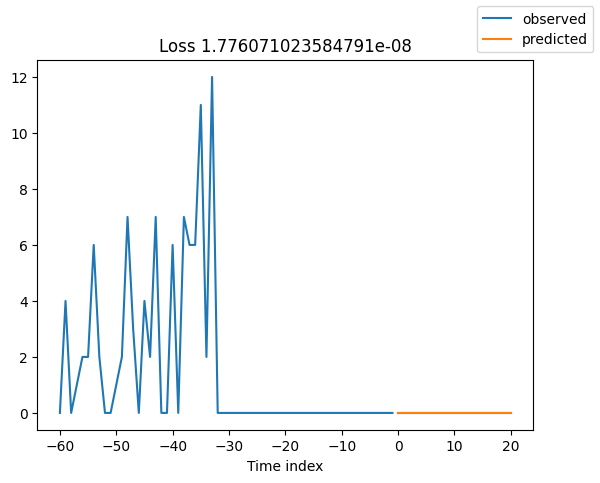

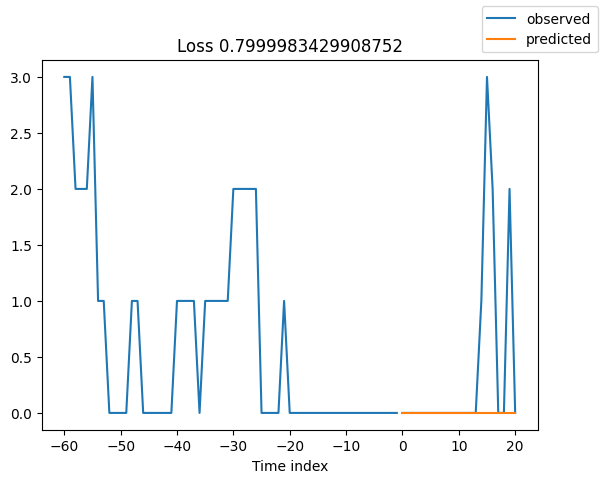

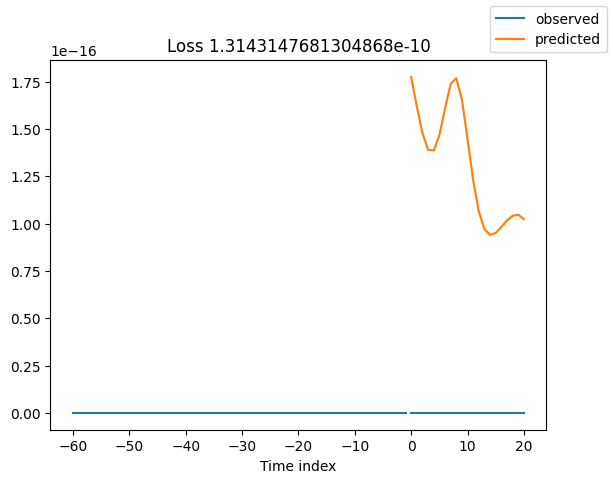

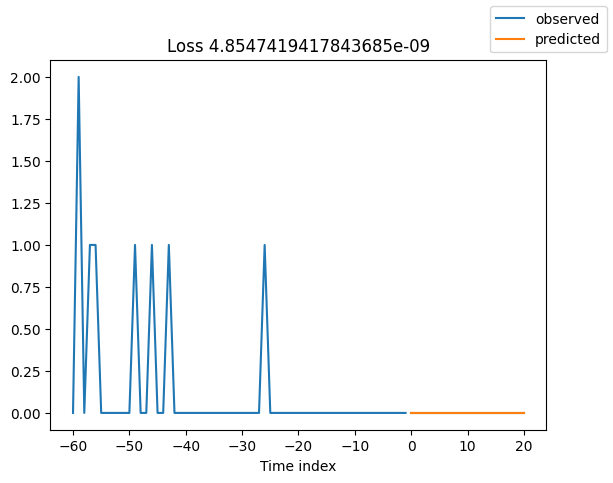

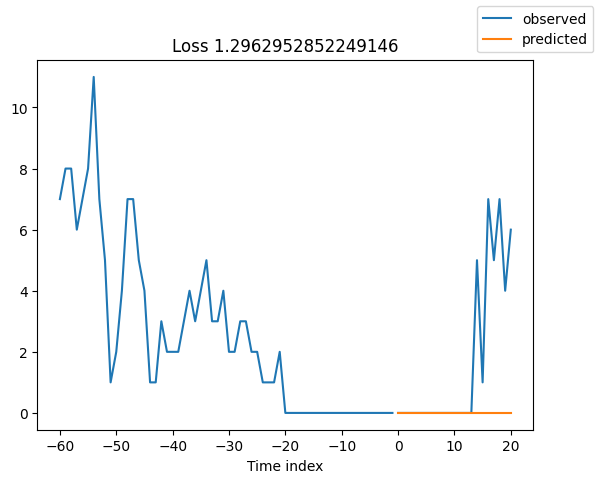

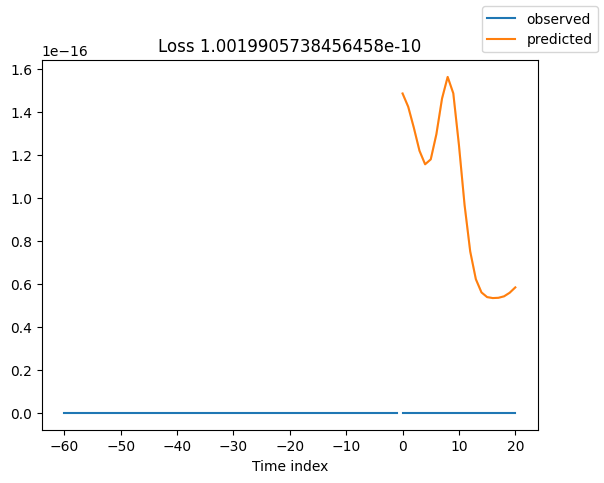

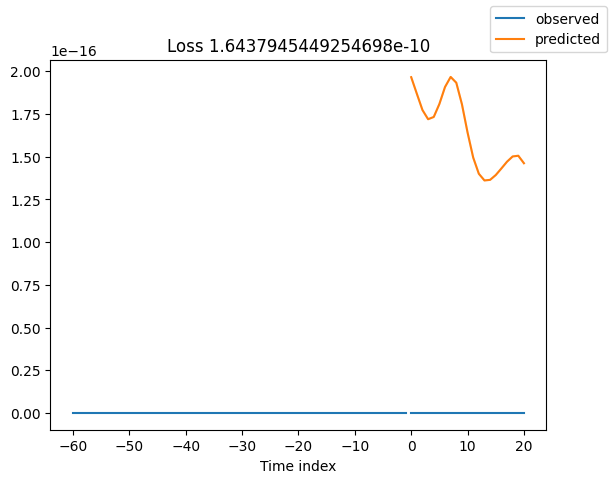

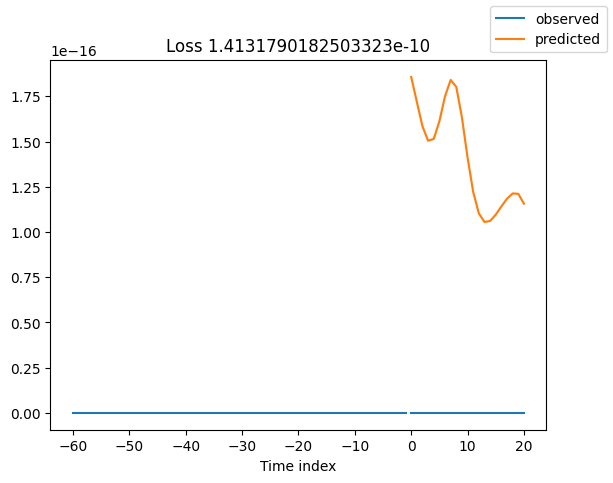

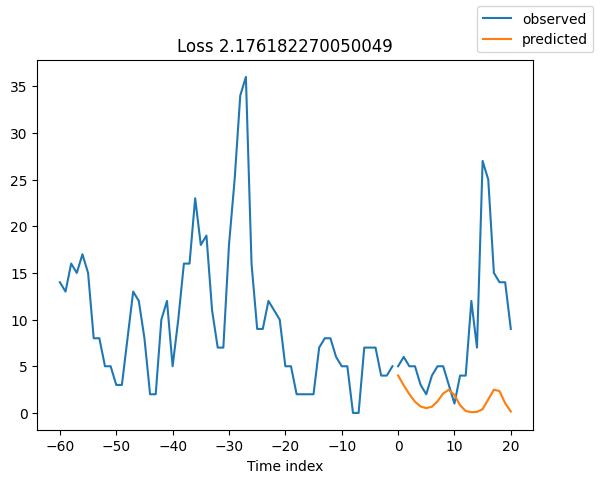

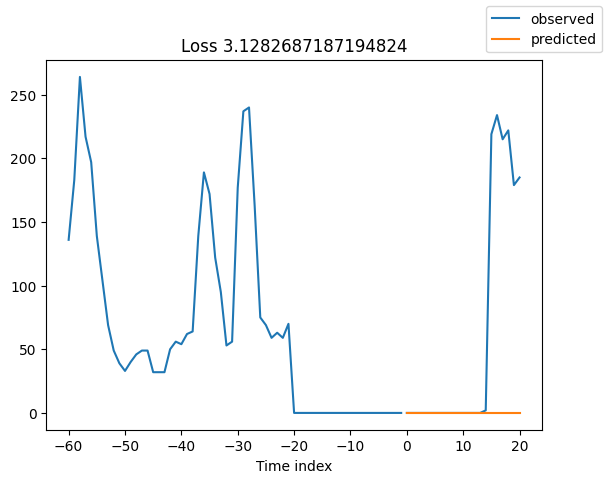

In [ ]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

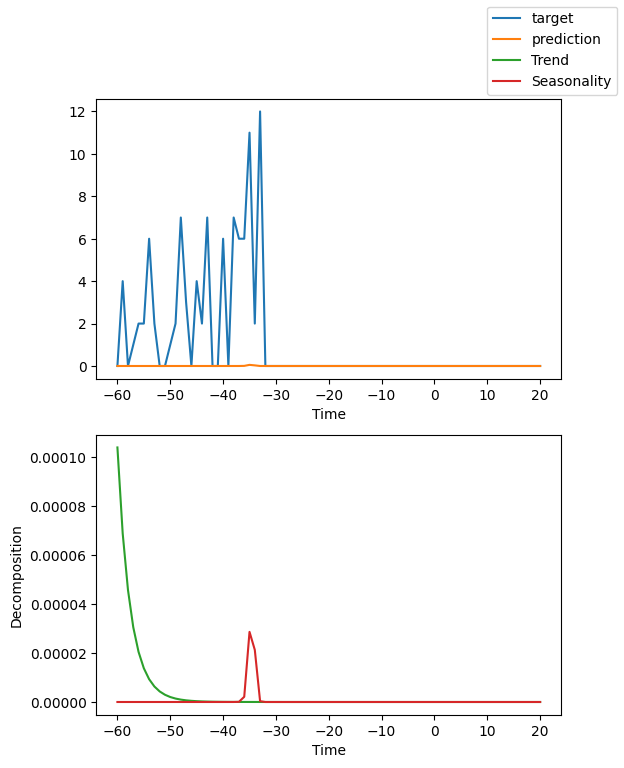

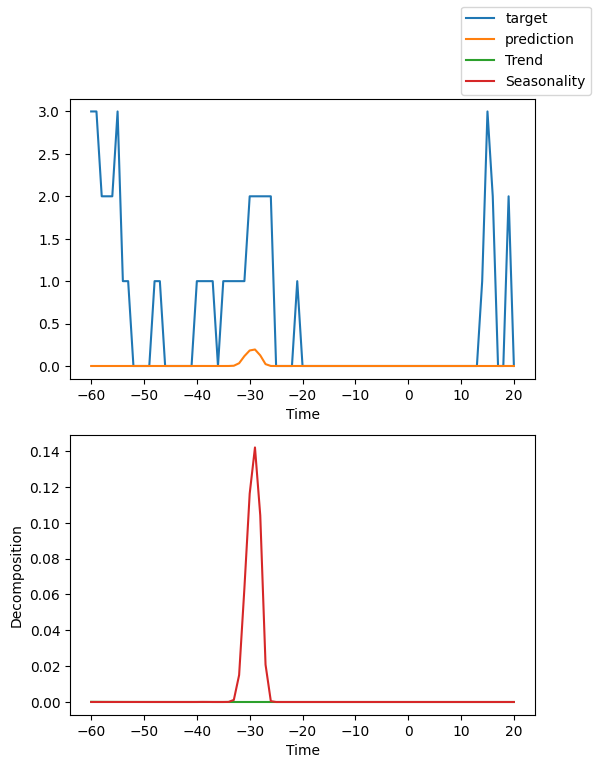

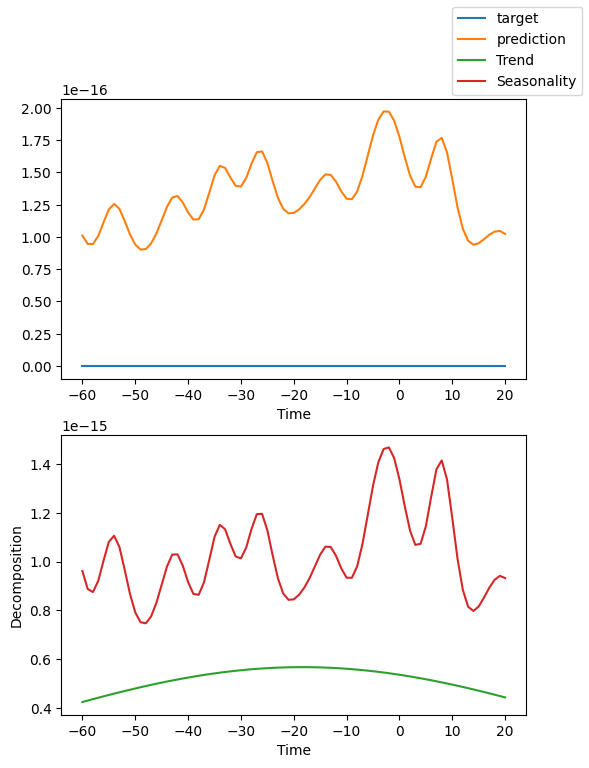

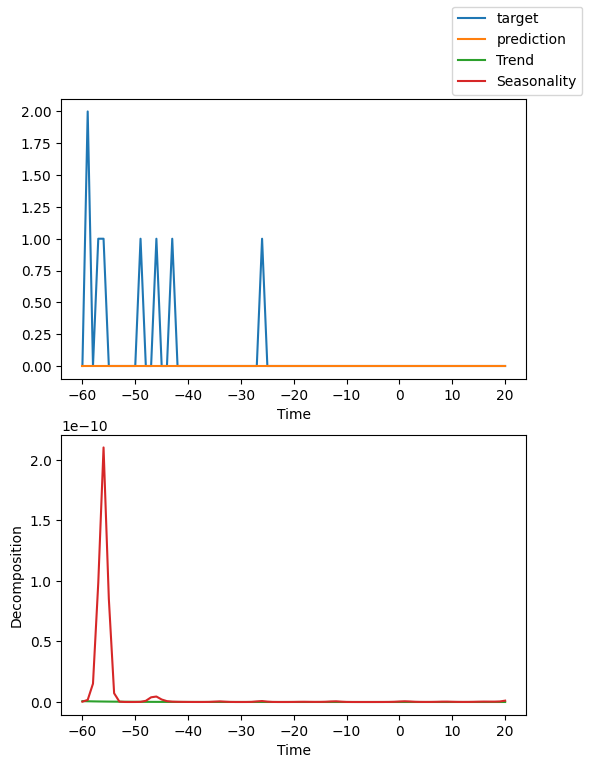

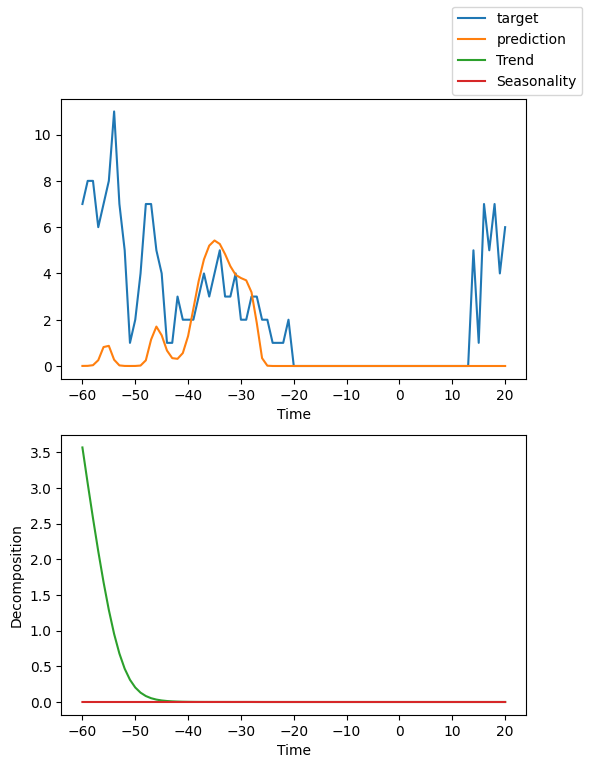

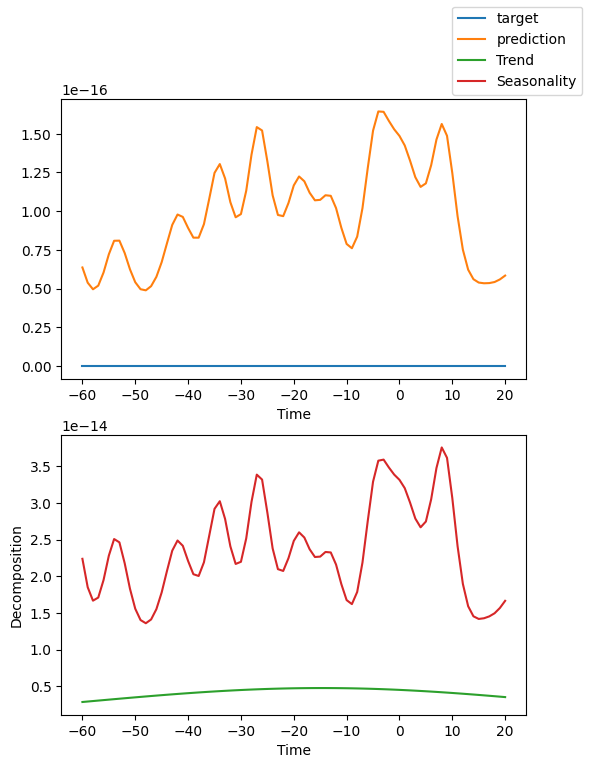

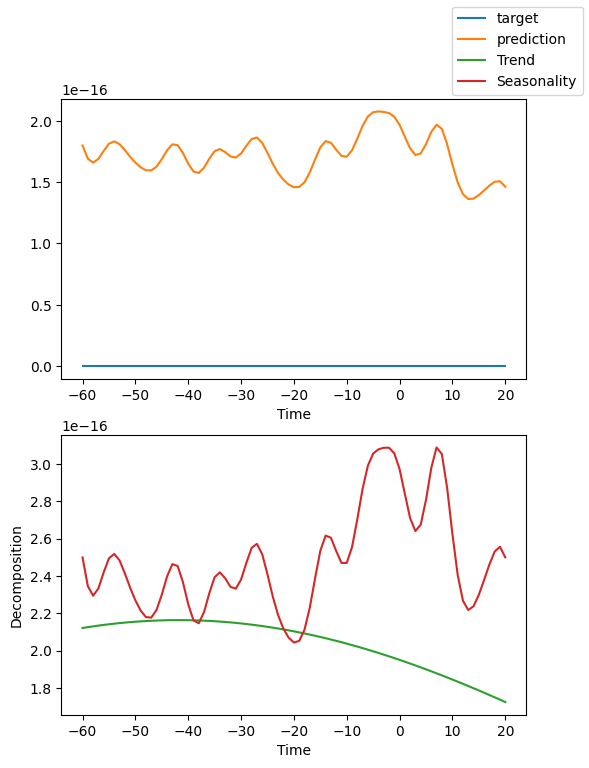

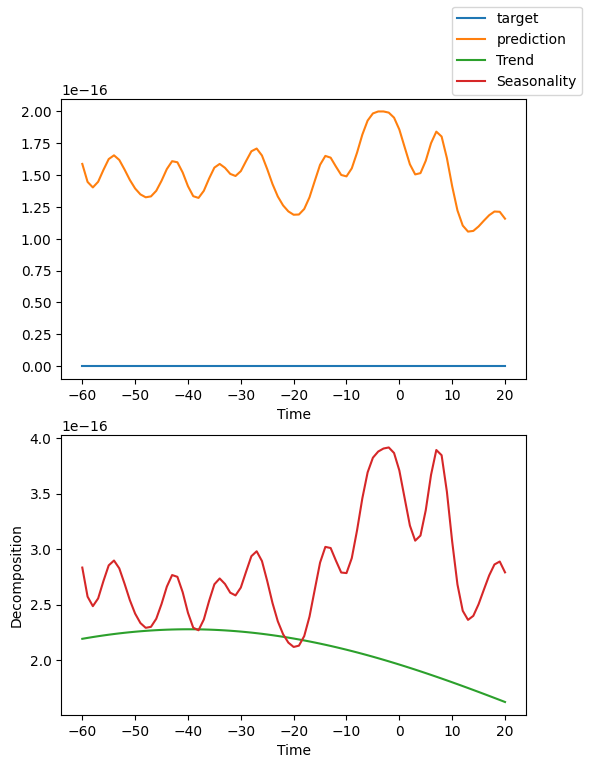

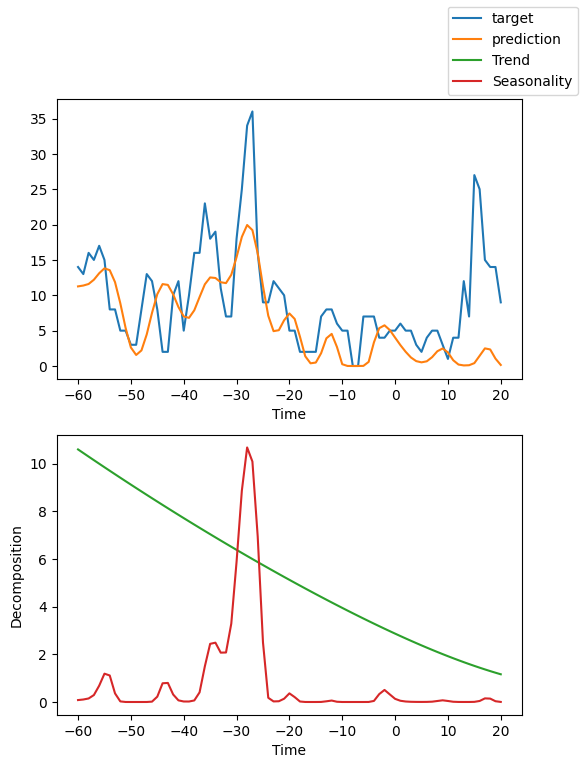

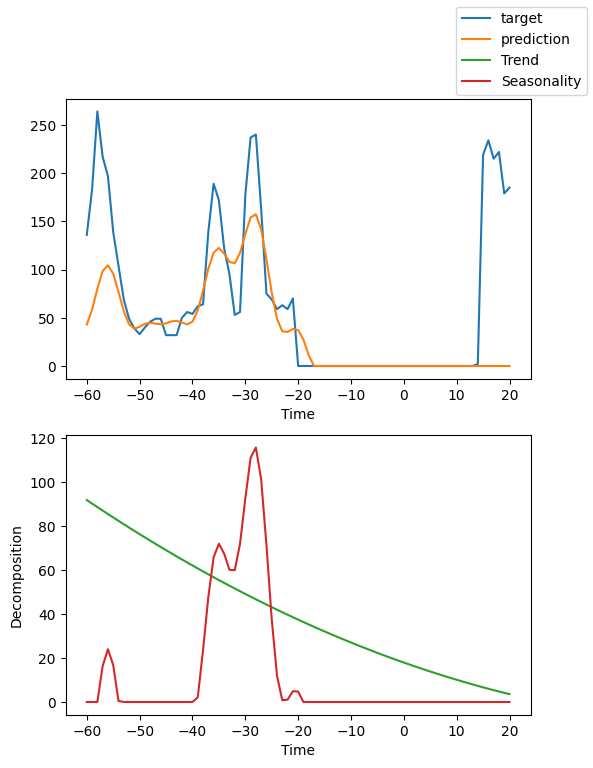

In [ ]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx)